In [1]:
# Parameters
system_name = "J2325-5229"


In [2]:
# Standard Python imports
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Astropy imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch
import astropy.io.fits as pyfits

# Lenstronomy imports
import lenstronomy
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util, util

# this is the linear inversion. The kwargs will be updated afterwards
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
import pickle

In [3]:
filename = f'joint_modeling/{system_name}/{system_name}_joint.pkl'

# load the saved data
with open(filename, "rb") as f:
    loaded_data = pickle.load(f)

kwargs_result = loaded_data["kwargs_result"]
multi_band_list = loaded_data["multi_band_list"]
kwargs_model = loaded_data["kwargs_model"]
kwargs_params = loaded_data.get("kwargs_params", None)
chain_list = loaded_data.get('chain_list')
kwargs_constraints = loaded_data.get("kwargs_constraints", None)
kwargs_likelihood = loaded_data.get("kwargs_likelihood", None)
kwargs_data_joint = loaded_data.get("kwargs_data_joint", None)

filters = ["F160W", "F814W", "F475X"]

point_source_list = [kwargs_model['point_source_model_list'][0]]
source_model_list = [kwargs_model['source_light_model_list'][0]]

ps_result = [kwargs_result['kwargs_ps'][0]]   
source_result = [kwargs_result['kwargs_source'][0]]

# index mapping for multi_band_list and kwargs_result
band_map = {"F160W": 0, "F814W": 1, "F475X": 2}

for filt in filters:
    print("\n" + "="*50)
    print(f"Processing filter: {filt}")
    print("="*50)

    i_band = band_map[filt]

    # Set up model components
    if filt == "F160W":
        lens_light_model_list = kwargs_model['lens_light_model_list'][0:1]  # two profiles
        lens_light_result = kwargs_result['kwargs_lens_light'][0:1]
    elif filt == "F814W":
        lens_light_model_list = [kwargs_model['lens_light_model_list'][2]]  # one profile
        lens_light_result = [kwargs_result['kwargs_lens_light'][2]]
    elif filt == "F475X":
        lens_light_model_list = [kwargs_model['lens_light_model_list'][3]]  # one profile
        lens_light_result = [kwargs_result['kwargs_lens_light'][3]]

    kwargs_data = multi_band_list[i_band][0]
    kwargs_psf = multi_band_list[i_band][1]
    kwargs_numerics = multi_band_list[i_band][2]

    psf_class = PSF(**kwargs_psf)
    likelihood_mask = kwargs_likelihood['image_likelihood_mask_list'][i_band]

    data_class = ImageData(**kwargs_data)
    lightModel = LightModel(lens_light_model_list)
    pointSource = PointSource(point_source_list)
    sourceModel = LightModel(source_model_list)
    lensModel = LensModel(lens_model_list=kwargs_model['lens_model_list'])

    imageModel = ImageModel(
        data_class=data_class,
        psf_class=psf_class,
        lens_model_class=lensModel,
        lens_light_model_class=lightModel,
        point_source_class=pointSource,
        source_model_class=sourceModel,
        kwargs_numerics=kwargs_numerics,
        likelihood_mask=likelihood_mask,
        psf_error_map_bool_list=[True]
    )

    imageLinearFit = ImageLinearFit(
        data_class=data_class,
        psf_class=psf_class,
        lens_model_class=lensModel,
        lens_light_model_class=lightModel,
        point_source_class=pointSource,
        source_model_class=sourceModel,
        kwargs_numerics=kwargs_numerics,
        likelihood_mask=likelihood_mask,
        psf_error_map_bool_list=[True]
    )

    # Flux calculations
    image_reconstructed, _, _, _ = imageLinearFit.image_linear_solve(
        kwargs_lens_light=lens_light_result,
        kwargs_ps=ps_result,
        kwargs_source=source_result,
        kwargs_lens=kwargs_result['kwargs_lens']
    )

    # Quasar flux
    ps_fluxes = [d['point_amp'] for d in ps_result]
    ps_flux_total = np.sum(ps_fluxes)

    # Lens galaxy flux
    image_lens = imageModel.lens_surface_brightness(lens_light_result)
    lens_flux = np.sum(image_lens)

    # Host galaxy (lensed)
    image_host_lensed = imageModel.source_surface_brightness(
        source_result,
        kwargs_lens=kwargs_result['kwargs_lens'],
        de_lensed=False
    )
    host_flux_lensed = np.sum(image_host_lensed)

    # Host galaxy (intrinsic)
    image_host_intrinsic = imageModel.source_surface_brightness(
        source_result,
        kwargs_lens=kwargs_result['kwargs_lens'],
        de_lensed=True
    )
    host_flux_intrinsic = np.sum(image_host_intrinsic)

    def prep_phot_pars_array():
        filename = f'cutout_data/{system_name}/{filt}/{system_name}_{filt}_cutout.fits'
        with fits.open(filename) as hdul:
            header = hdul[0].header
        photzpt = header['photzpt']
        photflam = header['photflam']
        photplam = header['photplam']
        return [photflam, photzpt, photplam]

    def get_stmag(electron_flux):
        photflam, photzpt, photplam = prep_phot_pars_array()
        flux = np.asarray(electron_flux)
        flux = flux * photflam
        return -2.5 * np.log10(flux) + photzpt

    def get_abmag(electron_flux):
        stmag = get_stmag(electron_flux)
        _, _, photplam = prep_phot_pars_array()
        return stmag - 5. * np.log10(photplam) + 2.5 * np.log10(299792458e10) - 27.5
    
    print("Point Source Flux:", ps_fluxes)
    print("Lens galaxy flux:", lens_flux)
    print("Host (lensed) flux:", host_flux_lensed)
    print("Host (intrinsic) flux:", host_flux_intrinsic)
    print(f"Image A AB mag: {get_abmag(ps_fluxes[0][0]):.2f}")
    print(f"Image B AB mag: {get_abmag(ps_fluxes[0][1]):.2f}")
    print(f"Lens AB mag: {get_abmag(lens_flux):.2f}")
    print(f"Host (lensed) AB mag: {get_abmag(host_flux_lensed):.2f}")
    print(f"Host (intrinsic) AB mag: {get_abmag(host_flux_intrinsic):.2f}")



Processing filter: F160W


/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


Point Source Flux: [array([146.10114966, 252.48736486])]
Lens galaxy flux: 1114.2431848464628
Host (lensed) flux: 975.3506377928469
Host (intrinsic) flux: 271.97537799986696
Image A AB mag: 20.53
Image B AB mag: 19.93
Lens AB mag: 18.32
Host (lensed) AB mag: 18.46
Host (intrinsic) AB mag: 19.85

Processing filter: F814W
Point Source Flux: [array([61.99290717, 46.62373934])]
Lens galaxy flux: 366.19230797717654
Host (lensed) flux: -26.04668900543472
Host (intrinsic) flux: -7.25623907889684
Image A AB mag: 20.63
Image B AB mag: 20.94
Lens AB mag: 18.70
Host (lensed) AB mag: nan
Host (intrinsic) AB mag: nan

Processing filter: F475X


Point Source Flux: [array([71.3506586 , 44.09929279])]
Lens galaxy flux: 157.9893774259592
Host (lensed) flux: -13.638573627069805
Host (intrinsic) flux: -3.8017870393166664
Image A AB mag: 21.50
Image B AB mag: 22.03
Lens AB mag: 20.64
Host (lensed) AB mag: nan
Host (intrinsic) AB mag: nan


/tmp/ipykernel_347316/4248854398.py:127: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + photzpt


/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


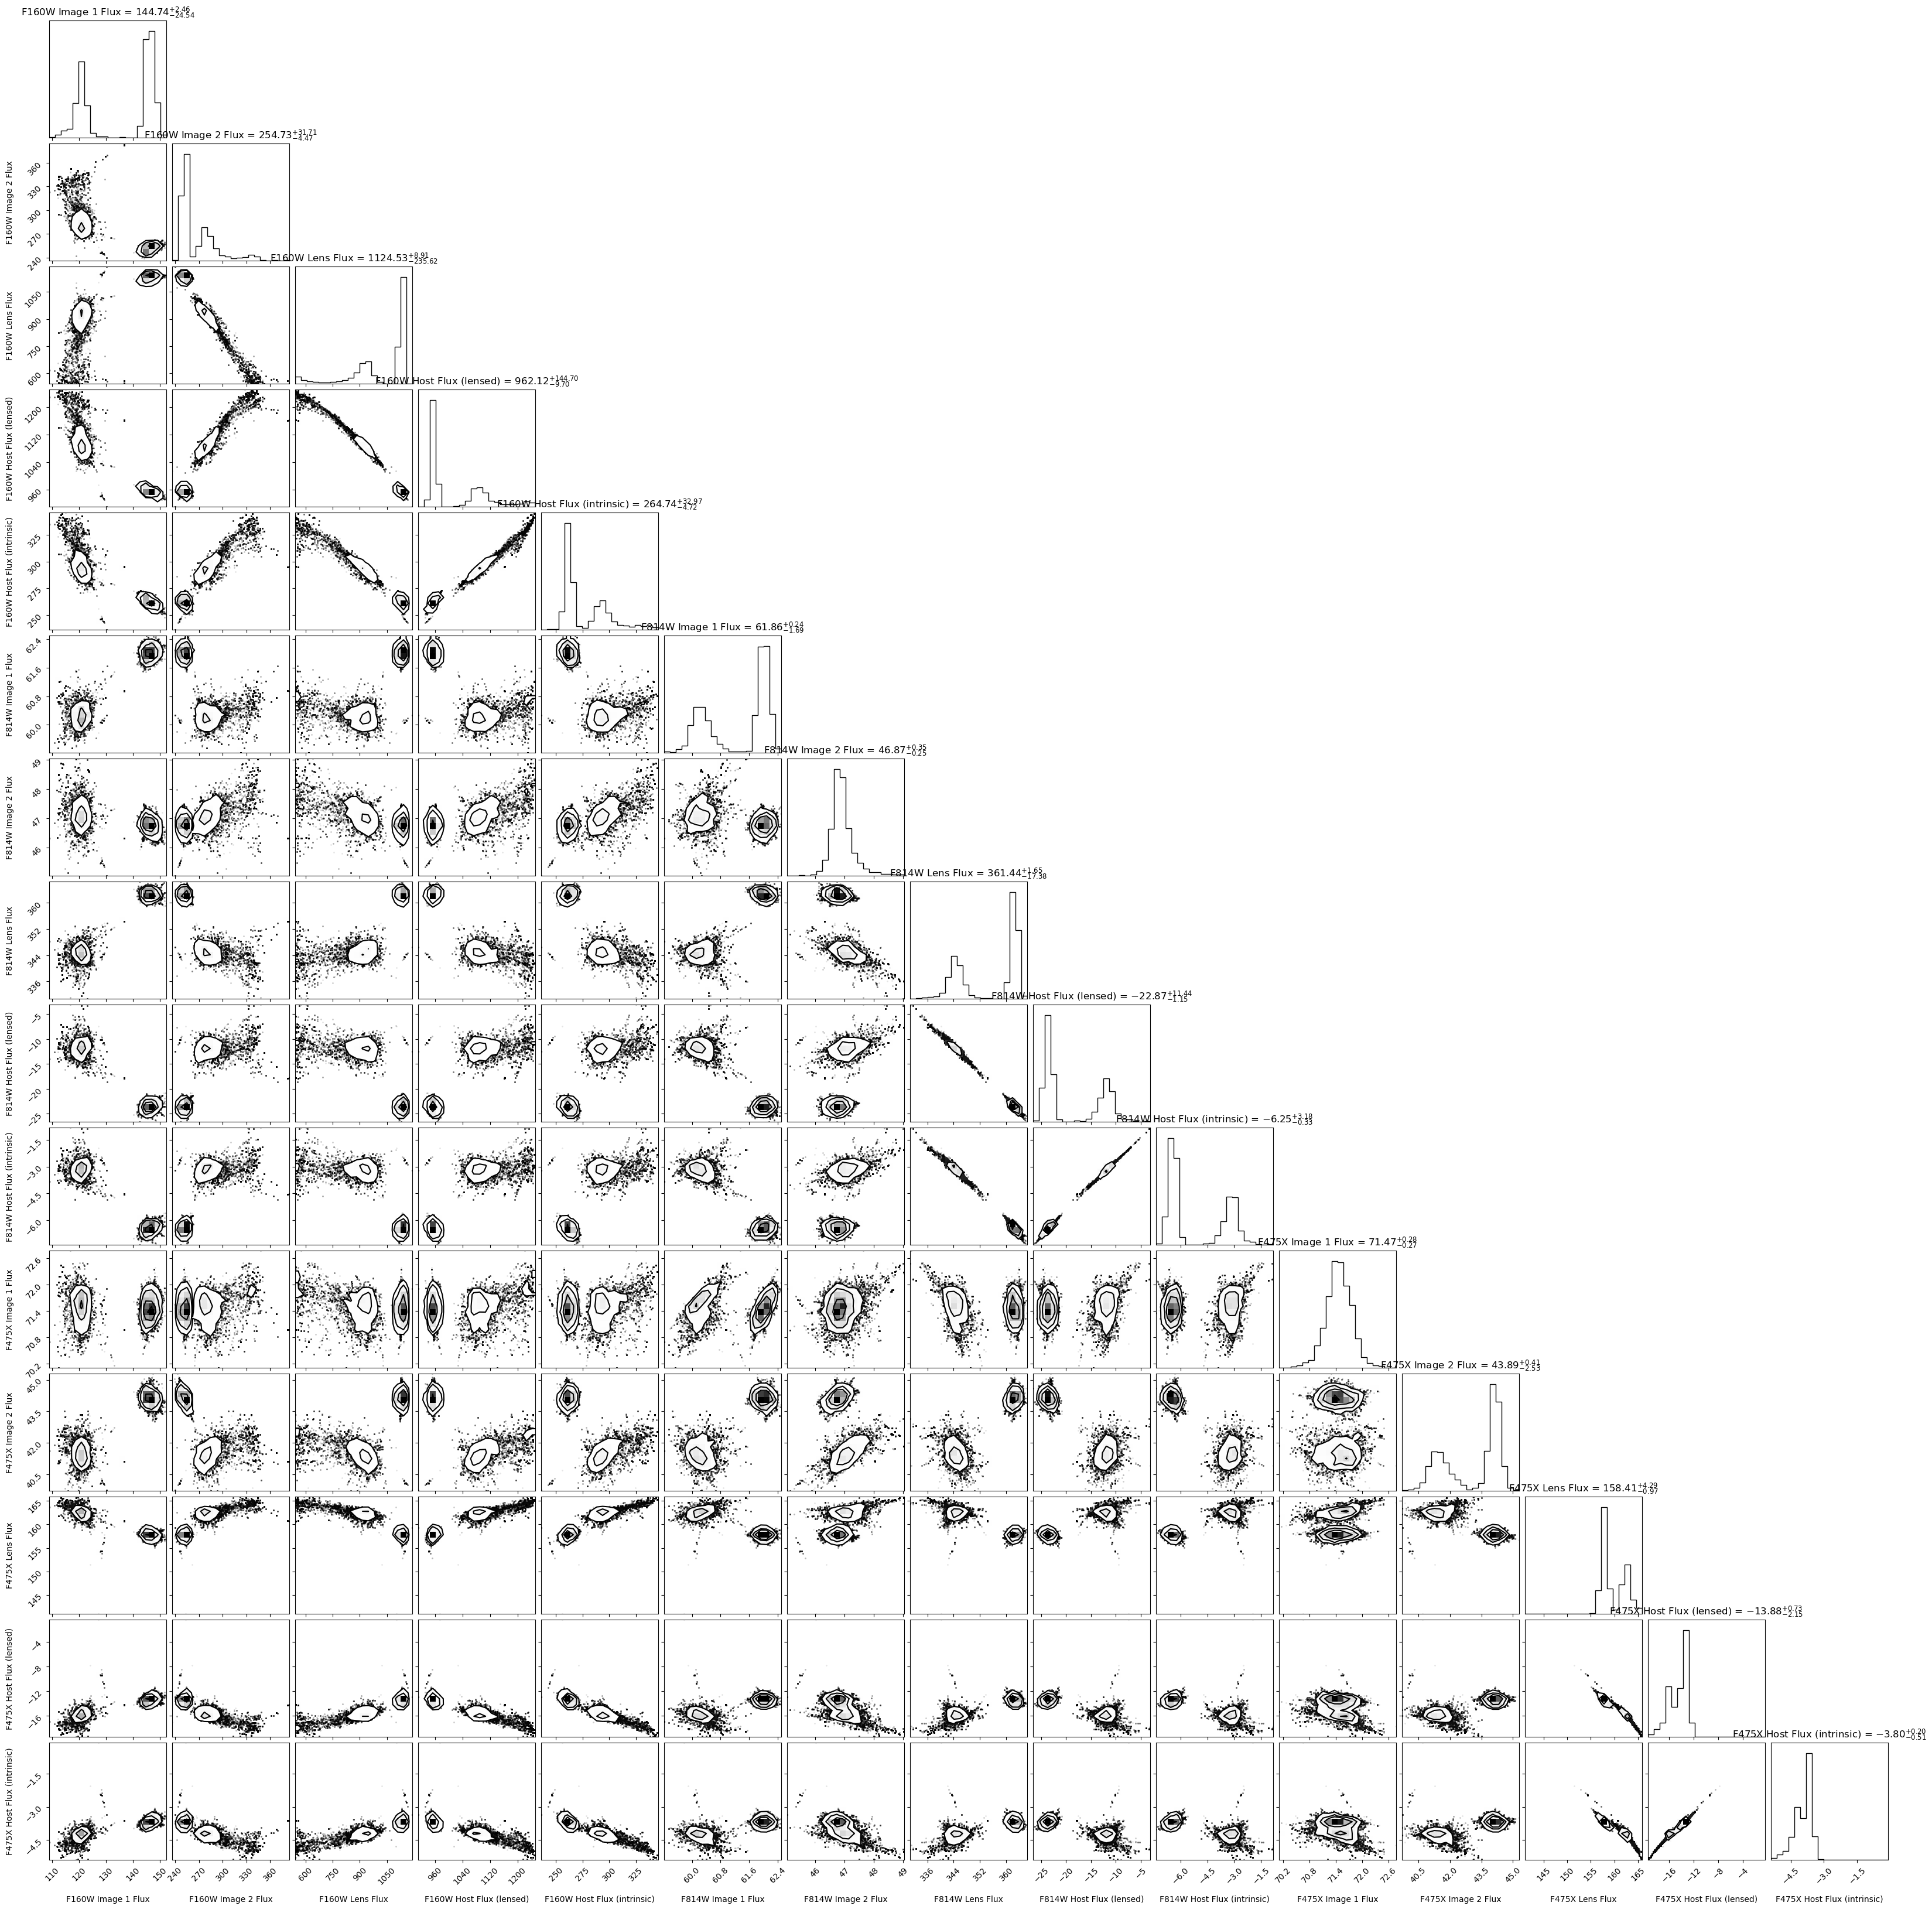

In [4]:
from lenstronomy.Sampling.parameters import Param
import corner

filters = ["F160W", "F814W", "F475X"]
band_map = {"F160W": 0, "F814W": 1, "F475X": 2}

sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[3]

# Set up the parameter object
param = Param(
    kwargs_model,
    kwargs_fixed_lens=[{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}],
    kwargs_fixed_lens_light=[{}, {}, {}, {}],
    kwargs_fixed_source=[{}],
    kwargs_fixed_ps=[{}],
    **kwargs_constraints
)

mcmc_flux_list = []

n_samples = len(samples_mcmc[::5]) # use every 5th sample

for i in range(n_samples):
    # convert MCMC sample to lenstronomy kwargs
    kwargs_out = param.args2kwargs(samples_mcmc[i])
    kwargs_lens_light_out = kwargs_out['kwargs_lens_light']
    kwargs_ps_out = kwargs_out['kwargs_ps']
    kwargs_source_out = kwargs_out['kwargs_source']
    kwargs_lens_out = kwargs_out['kwargs_lens']

    fluxes_this_sample = []

    for filt in filters:
        i_band = band_map[filt]

    # Reconstruct the image for this band
        kwargs_data = multi_band_list[i_band][0]
        kwargs_psf = multi_band_list[i_band][1]
        kwargs_numerics = multi_band_list[i_band][2]
        likelihood_mask = kwargs_likelihood['image_likelihood_mask_list'][i_band]
    
        data_class = ImageData(**kwargs_data)
        psf_class = PSF(**kwargs_psf)

    # Lens light per filter
        if filt == "F160W":
            lens_light_model_list = kwargs_model['lens_light_model_list'][0:1]
            lens_light_result = kwargs_lens_light_out[0:1]
        elif filt == "F814W":
            lens_light_model_list = [kwargs_model['lens_light_model_list'][2]]
            lens_light_result = [kwargs_lens_light_out[2]]
        elif filt == "F475X":
            lens_light_model_list = [kwargs_model['lens_light_model_list'][3]]
            lens_light_result = [kwargs_lens_light_out[3]]

    # Shared source and point-source models
        point_source_list = [kwargs_model['point_source_model_list'][0]]
        source_model_list = [kwargs_model['source_light_model_list'][0]]

        lightModel = LightModel(lens_light_model_list)
        pointSource = PointSource(point_source_list)
        sourceModel = LightModel(source_model_list)
        lensModel = LensModel(lens_model_list=kwargs_model['lens_model_list'])

        imageModel = ImageModel(
        data_class=data_class,
        psf_class=psf_class,
        lens_model_class=lensModel,
        lens_light_model_class=lightModel,
        point_source_class=pointSource,
        source_model_class=sourceModel,
        kwargs_numerics=kwargs_numerics,
        likelihood_mask=likelihood_mask,
        psf_error_map_bool_list=[True]
    )

        imageLinearFit = ImageLinearFit(
        data_class=data_class,
        psf_class=psf_class,
        lens_model_class=lensModel,
        lens_light_model_class=lightModel,
        point_source_class=pointSource,
        source_model_class=sourceModel,
        kwargs_numerics=kwargs_numerics,
        likelihood_mask=likelihood_mask,
        psf_error_map_bool_list=[True]
    )

    # --- Solve linear fluxes ---
        image_reconstructed, _, _, _ = imageLinearFit.image_linear_solve(
        kwargs_lens=kwargs_lens_out,
        kwargs_lens_light=lens_light_result,
        kwargs_ps=kwargs_ps_out,         
        kwargs_source=kwargs_source_out  
    )

    # Quasar fluxes
        flux_im1 = kwargs_ps_out[0]['point_amp'][0]
        flux_im2 = kwargs_ps_out[0]['point_amp'][1]

    # Lens flux
        flux_lens = np.sum(imageModel.lens_surface_brightness(lens_light_result))

    # Host flux
        flux_host_lensed = np.sum(imageModel.source_surface_brightness(kwargs_source_out, kwargs_lens_out, de_lensed=False))
        flux_host_intrinsic = np.sum(imageModel.source_surface_brightness(kwargs_source_out, kwargs_lens_out, de_lensed=True))

    # Append band fluxes
        fluxes_this_sample.extend([
        flux_im1, flux_im2, flux_lens, flux_host_lensed, flux_host_intrinsic
    ])

    

    # Append this sample to the full MCMC list
    mcmc_flux_list.append(fluxes_this_sample)

# Convert to numpy array
mcmc_flux_array = np.array(mcmc_flux_list)

# Generate corner plot
labels_joint = []
for filt in filters:
    labels_joint += [
        f"{filt} Image 1 Flux",
        f"{filt} Image 2 Flux",
        f"{filt} Lens Flux",
        f"{filt} Host Flux (lensed)",
        f"{filt} Host Flux (intrinsic)"
    ]

corner.corner(mcmc_flux_array, labels=labels_joint, show_titles=True)
plt.show()


In [5]:
# --- Helper function for median and 1-sigma uncertainties ---
def get_median_and_uncertainties(samples):
    median = np.median(samples)
    lower, upper = np.percentile(samples, [16, 84])
    return median, (upper - median, median - lower)

# --- Compute medians and uncertainties for every flux column ---
n_params = mcmc_flux_array.shape[1]  # 5 per filter
results_dict = {filt: {} for filt in filters}

for i, filt in enumerate(filters):
    start_idx = i * 5
    end_idx = start_idx + 5
    flux_labels = ["Image1", "Image2", "Lens", "Host_lensed", "Host_intrinsic"]
    
    # Load calibration parameters for this filter once
    filename = f'cutout_data/{system_name}/{filt}/{system_name}_{filt}_cutout.fits'
    with fits.open(filename) as hdul:
        header = hdul[0].header
    photzpt = header['photzpt']
    photflam = header['photflam']
    photplam = header['photplam']
    
    for j, label in enumerate(flux_labels):
        samples = mcmc_flux_array[:, start_idx + j]

        # --- Flux statistics ---
        flux_median, (flux_sigma_plus, flux_sigma_minus) = get_median_and_uncertainties(samples)

        # --- Magnitude statistics (propagate full posterior) ---
        abmag_samples = get_abmag(samples)
        mag_median, (mag_sigma_plus, mag_sigma_minus) = get_median_and_uncertainties(abmag_samples)

        results_dict[filt][label] = {
            "flux_median": flux_median,
            "flux_sigma_plus": flux_sigma_plus,
            "flux_sigma_minus": flux_sigma_minus,
            "mag_median": mag_median,
            "mag_sigma_plus": mag_sigma_plus,
            "mag_sigma_minus": mag_sigma_minus
        }

# --- Print results ---
for filt in filters:
    print(f"\nFilter: {filt}")
    for label, stats in results_dict[filt].items():
        print(
            f"{label:15s}: "
            f"Flux = {stats['flux_median']:.2f} (+{stats['flux_sigma_plus']:.2f}, -{stats['flux_sigma_minus']:.2f}) "
            f"| AB Mag = {stats['mag_median']:.2f} (+{stats['mag_sigma_plus']:.2f}, -{stats['mag_sigma_minus']:.2f})"
        )



Filter: F160W
Image1         : Flux = 144.74 (+2.46, -24.54) | AB Mag = 20.54 (+0.20, -0.02)
Image2         : Flux = 254.73 (+31.71, -4.47) | AB Mag = 19.92 (+0.02, -0.13)
Lens           : Flux = 1124.53 (+8.91, -235.62) | AB Mag = 18.31 (+0.26, -0.01)
Host_lensed    : Flux = 962.12 (+144.70, -9.70) | AB Mag = 18.48 (+0.01, -0.15)
Host_intrinsic : Flux = 264.74 (+32.97, -4.72) | AB Mag = 19.88 (+0.02, -0.13)

Filter: F814W
Image1         : Flux = 61.86 (+0.24, -1.69) | AB Mag = 20.63 (+0.03, -0.00)
Image2         : Flux = 46.87 (+0.35, -0.25) | AB Mag = 20.93 (+0.01, -0.01)
Lens           : Flux = 361.44 (+1.65, -17.38) | AB Mag = 18.72 (+0.05, -0.00)
Host_lensed    : Flux = -22.87 (+11.44, -1.15) | AB Mag = nan (+nan, -nan)
Host_intrinsic : Flux = -6.25 (+3.18, -0.33) | AB Mag = nan (+nan, -nan)

Filter: F475X
Image1         : Flux = 71.47 (+0.28, -0.27) | AB Mag = 21.50 (+0.00, -0.00)
Image2         : Flux = 43.89 (+0.41, -2.53) | AB Mag = 22.03 (+0.06, -0.01)
Lens           : Flux 

/tmp/ipykernel_347316/4248854398.py:127: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + photzpt


In [6]:
import h5py
import os
import numpy as np

outname = f'joint_modeling/{system_name}/{system_name}_photometry.hdf5'

with h5py.File(outname, 'w') as f:
    # --- Point source positions (shared across all filters) ---
    f.create_dataset('image_position', data=[ps_result[0]['ra_image'], ps_result[0]['dec_image']])

    # --- Loop over filters ---
    for filt in filters:
        grp = f.create_group(filt)  # create a group for each filter

        # --- Point source fluxes and magnitudes ---
        for idx, label in enumerate(["Image1", "Image2"]):
            stats = results_dict[filt][label]
            grp.create_dataset(f'image{idx+1}_flux', data=stats["flux_median"])
            grp.create_dataset(f'image{idx+1}_flux_sigma', data=[stats["flux_sigma_plus"], stats["flux_sigma_minus"]])
            grp.create_dataset(f'image{idx+1}_mag', data=stats["mag_median"])
            grp.create_dataset(f'image{idx+1}_mag_sigma', data=[stats["mag_sigma_plus"], stats["mag_sigma_minus"]])

        # --- Lens light parameters for this filter ---
        if filt == "F160W":
            lens_light_result = kwargs_lens_light_out[0:1]
        elif filt == "F814W":
            lens_light_result = [kwargs_lens_light_out[2]]
        elif filt == "F475X":
            lens_light_result = [kwargs_lens_light_out[3]]

        lens_grp = grp.create_group("lens_light")
        for i, result in enumerate(lens_light_result):
            comp_grp = lens_grp.create_group(f"component_{i}")
            for key, value in result.items():
                if key != 'amp':  # skip amp directly here
                    comp_grp.create_dataset(key, data=value)

        # --- Lens galaxy flux and magnitude ---
        lens_stats = results_dict[filt]["Lens"]
        grp.create_dataset('lens_flux', data=lens_stats["flux_median"])
        grp.create_dataset('lens_flux_sigma', data=[lens_stats["flux_sigma_plus"], lens_stats["flux_sigma_minus"]])
        grp.create_dataset('lens_mag', data=lens_stats["mag_median"])
        grp.create_dataset('lens_mag_sigma', data=[lens_stats["mag_sigma_plus"], lens_stats["mag_sigma_minus"]])

        # --- Host galaxy fluxes and magnitudes ---
        for host_label, dataset_prefix in zip(
            ["Host_lensed", "Host_intrinsic"],
            ["host_lensed", "host_intrinsic"]
        ):
            stats = results_dict[filt][host_label]
            grp.create_dataset(f'{dataset_prefix}_flux', data=stats["flux_median"])
            grp.create_dataset(f'{dataset_prefix}_flux_sigma', data=[stats["flux_sigma_plus"], stats["flux_sigma_minus"]])
            grp.create_dataset(f'{dataset_prefix}_mag', data=stats["mag_median"])
            grp.create_dataset(f'{dataset_prefix}_mag_sigma', data=[stats["mag_sigma_plus"], stats["mag_sigma_minus"]])

print(f"Saved results for all filters to {outname}")


Saved results for all filters to joint_modeling/J2325-5229/J2325-5229_photometry.hdf5
